<a href="https://colab.research.google.com/github/ronitavalani/467Project/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.stats import entropy
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Load dataset
url = 'https://raw.githubusercontent.com/ronitavalani/467Project/main/spotify_songs.csv'
df = pd.read_csv(url)

# Features and target
features = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# Feature engineering
engineered_features = [
    'rhythm_energy', 'brightness', 'percussive_power', 'energy_valence',
    'tempo_dance', 'speech_loud', 'valence_acoustic', 'speech_mode', 'tempo_valence'
]

for feat in engineered_features:
    if feat == 'rhythm_energy':
        df[feat] = df['danceability'] * df['energy']
    elif feat == 'brightness':
        df[feat] = df['valence'] * (1 - df['acousticness'])
    elif feat == 'percussive_power':
        df[feat] = df['loudness'] * (1 - df['acousticness'])
    elif feat == 'energy_valence':
        df[feat] = df['energy'] * df['valence']
    elif feat == 'tempo_dance':
        df[feat] = df['tempo'] * df['danceability']
    elif feat == 'speech_loud':
        df[feat] = df['speechiness'] * df['loudness']
    elif feat == 'valence_acoustic':
        df[feat] = df['valence'] * df['acousticness']
    elif feat == 'speech_mode':
        df[feat] = df['speechiness'] * df['mode']
    elif feat == 'tempo_valence':
        df[feat] = df['tempo'] * df['valence']

# Drop missing values
df = df.dropna(subset=features + ['playlist_genre'])

# Prepare features and target
X = df[features + engineered_features]
y = df['playlist_genre']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Standardize features
X = StandardScaler().fit_transform(X)

# Train/dev/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Function to compute Class Overlapping-Balancing Entropy
def class_entropy(y_true, y_pred):
    cm = pd.crosstab(y_true, y_pred, normalize='index')
    row_entropies = cm.apply(lambda row: entropy(row + 1e-8, base=2), axis=1)  # add small constant to avoid log(0)
    return row_entropies.mean()

# Hyperparameter test set
param_grid = [
    {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100},
    {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200},
    {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 150},
    {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300},
]

# Store results
results = []

# Run tests
for params in param_grid:
    model = XGBClassifier(
        **params,
        reg_alpha=1,
        reg_lambda=2,
        gamma=0.3,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)
    y_dev_pred = model.predict(X_dev)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_dev = accuracy_score(y_dev, y_dev_pred)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    ent_dev = class_entropy(y_dev, y_dev_pred)
    results.append({**params, 'train_acc': acc_train, 'dev_acc': acc_dev, 'test_acc': acc_test, 'entropy': ent_dev})

# Display results in table
results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df.sort_values(by='dev_acc', ascending=False).to_string(index=False))

# Select and evaluate the best model on test set
best_row = results_df.sort_values(by='dev_acc', ascending=False).iloc[0]
best_params = {
    'max_depth': int(best_row['max_depth']),
    'learning_rate': float(best_row['learning_rate']),
    'n_estimators': int(best_row['n_estimators']),
}
print("\nRetraining best model on full training set with params:", best_params)

final_model = XGBClassifier(
    **best_params,
    reg_alpha=1,
    reg_lambda=2,
    gamma=0.3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
final_model.fit(X_train, y_train)

# Train eval
train_pred = final_model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print("\nTrain Set Accuracy (Best Model):", train_acc)

# Final test evaluation
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print("\nFinal Test Set Accuracy (Best Model):", final_acc)
print("\nClassification Report:")
print(classification_report(y_test, final_pred, target_names=le.classes_))



Hyperparameter Tuning Results:
 max_depth  learning_rate  n_estimators  train_acc  dev_acc  test_acc  entropy
         5           0.10           200   0.709275 0.558398  0.552002 1.884850
         6           0.05           150   0.670694 0.554896  0.548500 1.893116
         4           0.10           100   0.601909 0.546673  0.543170 1.923517
         4           0.03           300   0.598609 0.546520  0.539973 1.924232
         3           0.05           100   0.546576 0.520024  0.523984 1.992409

Retraining best model on full training set with params: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200}

Train Set Accuracy (Best Model): 0.7092745824661151

Final Test Set Accuracy (Best Model): 0.5520024364245469

Classification Report:
              precision    recall  f1-score   support

         edm       0.69      0.68      0.68      1209
       latin       0.53      0.43      0.47      1031
         pop       0.37      0.36      0.37      1101
         r&b       0.48  

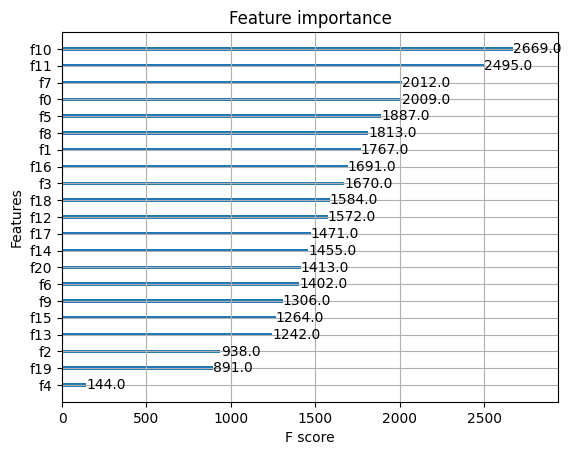

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(final_model)
plt.show()


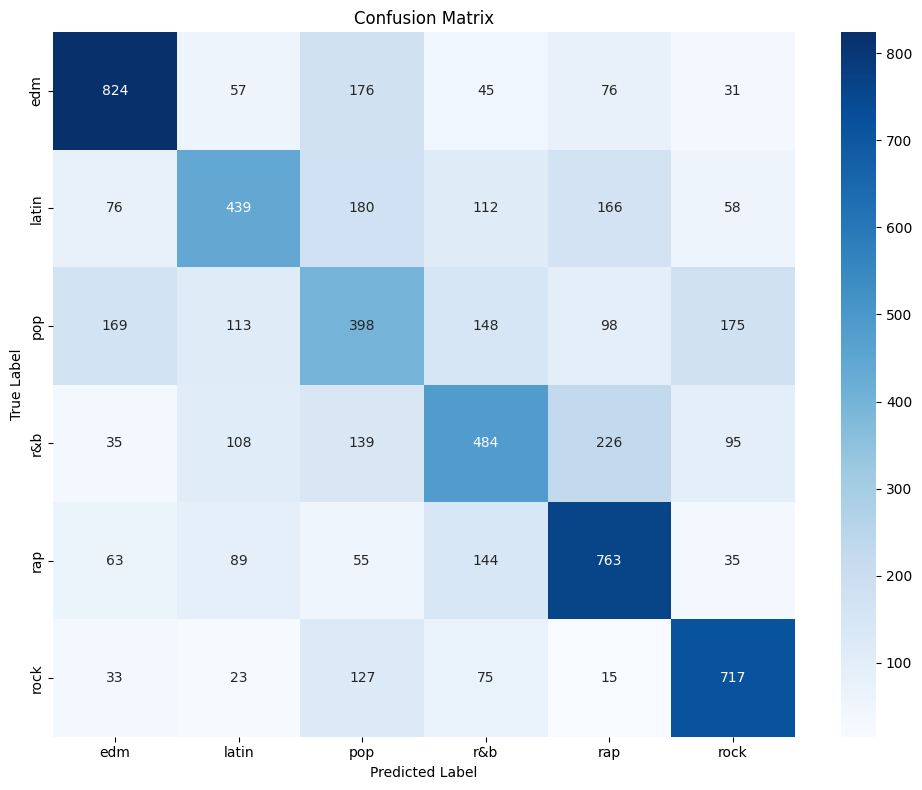

In [ ]:
cm = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
# plt.savefig('confusion_matrix.png')
plt.close()

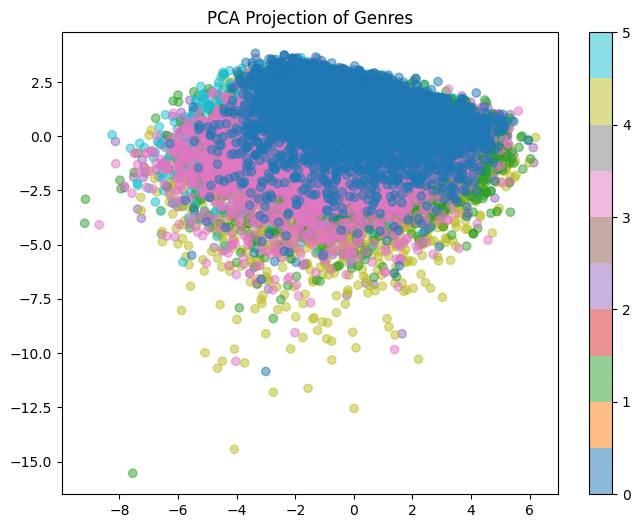

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.5)
plt.title("PCA Projection of Genres")
plt.colorbar()
plt.show()



Retraining best model on full training set with params: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200}

Train Set Accuracy (Best Model): 0.7092745824661151

Final Test Set Accuracy (Best Model): 0.5520024364245469

Classification Report:
              precision    recall  f1-score   support

         edm       0.69      0.68      0.68      1209
       latin       0.53      0.43      0.47      1031
         pop       0.37      0.36      0.37      1101
         r&b       0.48      0.45      0.46      1087
         rap       0.57      0.66      0.61      1149
        rock       0.65      0.72      0.68       990

    accuracy                           0.55      6567
   macro avg       0.55      0.55      0.55      6567
weighted avg       0.55      0.55      0.55      6567



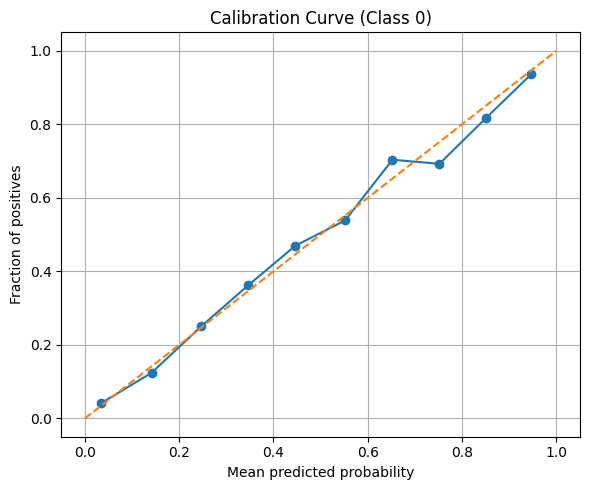

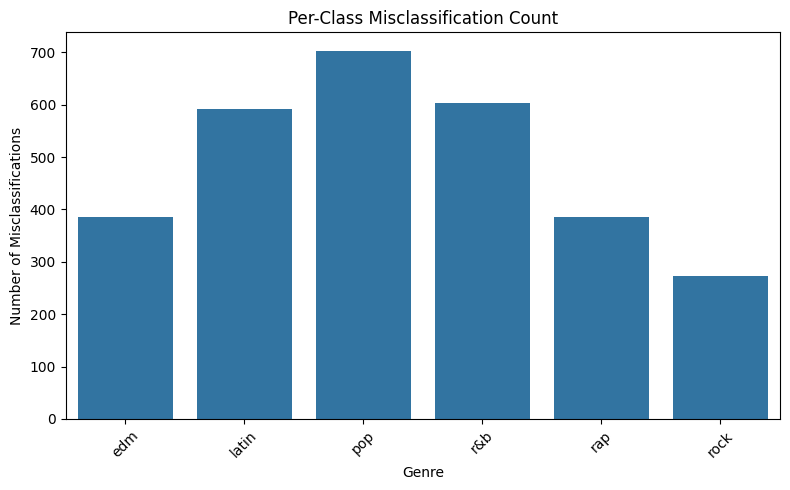

In [ ]:

best_row = results_df.sort_values(by='dev_acc', ascending=False).iloc[0]
best_params = {
    'max_depth': int(best_row['max_depth']),
    'learning_rate': float(best_row['learning_rate']),
    'n_estimators': int(best_row['n_estimators']),
}
print("\nRetraining best model on full training set with params:", best_params)

final_model = XGBClassifier(
    **best_params,
    reg_alpha=1,
    reg_lambda=2,
    gamma=0.3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
final_model.fit(X_train, y_train)

train_pred = final_model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print("\nTrain Set Accuracy (Best Model):", train_acc)

final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print("\nFinal Test Set Accuracy (Best Model):", final_acc)
print("\nClassification Report:")
print(classification_report(y_test, final_pred, target_names=le.classes_))

# Calibration plot (OvR, using one class as example)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay

# One-vs-rest probability for class 0
probs = final_model.predict_proba(X_test)
prob_true, prob_pred = calibration_curve(label_binarize(y_test, classes=np.arange(len(le.classes_)))[:, 0], probs[:, 0], n_bins=10)
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Calibration Curve (Class 0)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.grid(True)
plt.tight_layout()
plt.show()

# Per-class error histogram
misclassified = y_test != final_pred
error_counts = pd.Series(y_test[misclassified]).value_counts().sort_index()
class_labels = le.classes_
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=error_counts.reindex(range(len(class_labels)), fill_value=0).values)
plt.title('Per-Class Misclassification Count')
plt.ylabel('Number of Misclassifications')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()